<a href="https://colab.research.google.com/github/hatimnaitlho/ml-sklearn/blob/master/titanic_survival_prediction_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification: Titanic Survival Prediction Model

The RMS Titanic sank on April 15, 1912, during her maiden voyage, killing 1502 out of 2224 passengers and crew. The shipwreck led to such loss of life as there were not enough lifeboats for the passengers and crew. Although some groups of people were more likely to survive than others, such as women, children, and the upper-class.

## Goal and scope of the analysis
In this notebook, you will implement the following classification models in sklearn and assess there performance:
- Decision tree
- Support Vector Machine
- Ensemble Methods
- Logistic Regression


Note: Tuning models' hyperparameters is outside the scope of this notebook

We'll start by loading the dataset and displaying some of its rows.

# Getting started

In [0]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns


# Pretty display for notebooks
%matplotlib inline

# Set a random seed fot the notebook to be stable
import random
random.seed(42)


In [0]:
path='https://raw.githubusercontent.com/hatimnaitlho/ml-sklearn/master/datasets/titanic_data.csv'
data=pd.read_csv(path)

In [58]:
data.shape

(891, 12)

In [59]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

Recall that these are the various features present for each passenger on the ship:
- **PassengerId**: A unique Id for each passenger
- **Survived**: Outcome of survival (0 = No; 1 = Yes)
- **Pclass**: Socio-economic class (1 = Upper class; 2 = Middle class; 3 = Lower class)
- **Name**: Name of the passenger
- **Sex**: Sex of the passenger
- **Age**: Age of the passenger (Some entries contain `NaN`)
- **SibSp**: Number of siblings and spouses of the passenger aboard
- **Parch**: Number of parents and children of the passenger aboard
- **Ticket**: Ticket number of the passenger
- **Fare**: Fare paid by the passenger
- **Cabin**: Cabin number of the passenger (Some entries contain NaN)
- **Embarked**: Port of embarkation of the passenger (C = Cherbourg; Q = Queenstown; S = Southampton)

Since we're interested in the outcome of survival for each passenger or crew member, we can remove the **Survived** feature from this dataset and store it as its own separate variable `outcomes`. We will use these outcomes as our prediction targets.  

In [60]:
# Fill empty and NaNs values with NaN
data = data.fillna(np.nan)

# Check for Null values
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In the Titanic dataset we have missings in the age, cabin and embarked column. We have to perform some data cleansing otherwise we run the risk to have models that produce poor predictions.

# Exploratory Data Analysis

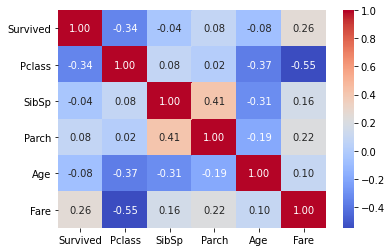

In [61]:
# Correlation matrix between numerical values: Survived, SibSp Parch Age and Fare values 
g = sns.heatmap(data[['Survived','Pclass', 'SibSp','Parch','Age','Fare']].corr(),
                annot=True, fmt = ".2f", cmap = 'coolwarm')

`Pclass` and `Fare` features have significant correlation with `Survived` feature

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3672: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


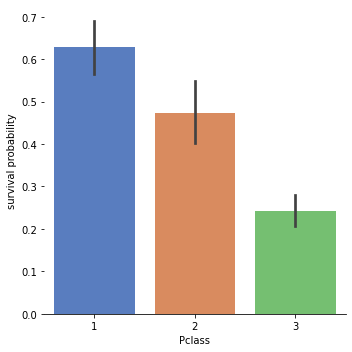

In [62]:
# Explore Pclass feature vs Survived
g = sns.factorplot(x="Pclass",y="Survived",data=data,kind="bar", size = 5 , palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

Recall what Pclass features is about the Socio-economic class 
- 1 = Upper class 
- 2 = Middle class 
- 3 = Lower class

Passengers in the upper class three times of chances to survive as passengers in the lower class.

# Imputation of Missing Data/ Outliers
We don´t want to delete all rows with missing values, therefore we will replace the missings when pertinent. 

## Age
We will visualize distribution of some features against age to identify some patterns that may help us fill the missing value.
As we can see, Age column contains 177 missing values in the titanic dataset.

Since there is subpopulations that have more chance to survive (children for example), it is preferable to keep the age feature and to impute the missing values.

To adress this problem, we have to focus on the most correlated features with Age to decide which strategy to adopt:
- Pclass, Parch,  or SibSP.


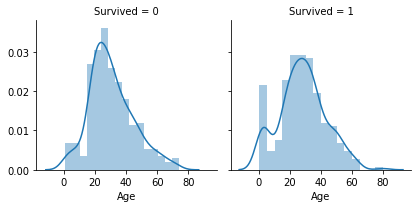

In [63]:
# Explore Age vs Survived
g = sns.FacetGrid(data, col='Survived')
g = g.map(sns.distplot, 'Age')

In [64]:
print('Median for "Age" grouped by "Pclass" and "Sex": ')
data.groupby(['Pclass', 'Sex'])['Age'].median()

Median for "Age" grouped by "Pclass" and "Sex": 


Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

Now, let's replace the missing values by the median of each group.

In [0]:
data['Age']= data.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

## Cabin
We can ignore the feature cabin for two reasons:
- 687 of records are missing, which represents 77% of the global values of this feature. 
- cabins and 'Pclass' feature are strongly linked
Thus we will simply remove the column 'Cabin'

In [0]:
data.drop(columns='Cabin', inplace= True)

## Embarked

We have two missing values in the 'Embarked' feature. We will replace them by the most common one.

In [67]:
data.loc[data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,NaN


In [68]:
df=data.groupby(['Embarked']).count()
df['PassengerId']

Embarked
C    168
Q     77
S    644
Name: PassengerId, dtype: int64

In [0]:
#Let's fill missing data with the most prevalent value
data.iloc[61,10]= 'S'
data.iloc[829,10]= 'S'

In [70]:
data.isnull().sum() 

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

## PassengerId
The feature ‘PassengerId’ does not bring relevant information or have an impact to a person survival probability.
So, we will drop this feature from our dataset 

In [0]:
data.drop(columns='PassengerId', inplace= True)

Now, we have filled all missing data. So we can go further on this project.

# Data Transformation and Features Engineering

In [72]:
# Store the 'Survived' feature in a new variable and remove it from the dataset
outcomes = data['Survived']
features = data.drop('Survived', axis = 1)

# Show the new dataset with 'Survived' removed
print(features.shape)
features.head()

(891, 9)


,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


#### One-hot encoding

Now, let's do some data preprocessing. First, we'll one-hot encode the features.

In [73]:
features_encod = pd.get_dummies(features)
print(features_encod.shape)

(891, 1582)


### Scaling data


In [0]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X= features_encod
y= outcomes

# scale and standarize data 
X_std= scaler.fit_transform(X)


# Model Building

Now we're ready to train models in sklearn using the transformed dataset. However, let's first, calculate the probability of random predictions that a passenger survived.

This probability is important because, it allow us to assess the performance of our models.

In [75]:
# calculates the probability of a random prediction model
survivor_count= outcomes.value_counts()
p= survivor_count[1]/(survivor_count[0]+ survivor_count[1])
round(p,4)

0.3838

The `accuracy` of a model that produces random predictions about Titanic survivors is equal to 0.3838. 

This step is very important, because `accuracy` is not an absolute value, and we have to look to random prediction to see if our model performs well.

## Training and assessing the models

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

classifiers= [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), 
              AdaBoostClassifier(), KNeighborsClassifier(3), BaggingClassifier(), ExtraTreesClassifier() ]



l1, l2, l3 =([] for i in range(3))

metrics_dict = {}


# split data on training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_std, outcomes, test_size=0.10, random_state=42)


for clf in classifiers:
  clf.fit(X_train, y_train)
  clf.predict(X_test)
  name= clf.__class__.__name__
  l1.append(name)
  metrics_dict['model']= l1
  l2.append(f1_score(y_test, clf.predict(X_test)))
  metrics_dict['f1_score']= l2
  l3.append(accuracy_score(y_test, clf.predict(X_test)))
  metrics_dict['accuracy_score'] = l3


df = pd.DataFrame(metrics_dict)
df


,model,f1_score,accuracy_score
0,LogisticRegression,0.818182,0.866667
1,DecisionTreeClassifier,0.800000,0.833333
2,RandomForestClassifier,0.782609,0.833333
3,AdaBoostClassifier,0.810811,0.844444
4,KNeighborsClassifier,0.537037,0.444444
5,BaggingClassifier,0.771429,0.822222
6,ExtraTreesClassifier,0.821918,0.855556


Recall that the random model had an accuracy of 0.3838. So, all the models we used performs very well campared to it. 

F1 Score which is the weighted average of Precision and Recall provide us additional information about how each model performs.

In practice, this is the first stage in building models that performs well and don't suffer from overfitting (or underfitting). Thus, we can choose the best models (Logistic Regression, Extra Trees Classifier, Random Forest Classifier, Ada Boost Classifier) and tune their respective hyper-parameters to produce most accurate predictions using some advanced machine learning techniques.